# 1. Carregar os datasets

Começamos fazendo os imports necessários e carregando os datasets que iremos usar.

In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
# Abrimos o arquivo json.
with open("datasets/BASE A/premium_students.json", "r") as read_file:
    data = json.load(read_file)

In [3]:
# Inicializamos o dataframe.
m = len(data)
id_list = [list(data[i].values())[0] for i in range(m)]
index = pd.Index(id_list, name='StudentId')
df = pd.DataFrame(np.zeros((m, 2)), columns=['RegisteredDate', 'SubscriptionDate'], index=index)

O dataframe **df** irá receber as datas de quando occorreram os registros e inscrições de plano premium. Para isso, iremos colocar as datas no formato datetime. 

In [4]:
# Arrumamos o formato das datas para timestamp.
for i in range(m):
    date = datetime.datetime.strptime(data[i]['RegisteredDate'], '%Y-%m-%d %H:%M:%S.%f')
    date = datetime.datetime.strptime(str(date.year) + '-' + str(date.month) + '-' + str(date.day), '%Y-%m-%d')
    data[i]['RegisteredDate'] = date
    
    date = datetime.datetime.strptime(data[i]['SubscriptionDate'], '%Y-%m-%d %H:%M:%S.%f')
    date = datetime.datetime.strptime(str(date.year) + '-' + str(date.month) + '-' + str(date.day), '%Y-%m-%d')
    data[i]['SubscriptionDate'] = date

# Atualizamos as colunas do dataframe.
df['RegisteredDate'] = [data[i]['RegisteredDate'] for i in range(m)]
df['SubscriptionDate'] = [data[i]['SubscriptionDate'] for i in range(m)]
    
df.head()

,RegisteredDate,SubscriptionDate
StudentId,,
98723802,2017-11-01,2017-11-01
86905029,2017-11-01,2017-11-17
40935842,2017-11-01,2017-11-01
83184096,2017-11-01,2018-05-18
12771137,2017-11-01,2017-11-01


Antes de proceder para as análises de fato, é prudente verificar se não há dados omissos ou duplicatas. 

In [5]:
# Podemos ver que não há nenhum NaN nos dados. De fato isto é esperado, caso houvesse iríamos obter um erro na hora de
# converter para datetime acima.
print(np.sum(df.isna()), '\n')

# Verificamos que não há alguma StudentId repetida. Caso houvesse, simplesmente apagaríamos as duplicatas.
print(len(set(df.index)) == df.shape[0])

RegisteredDate      0
SubscriptionDate    0
dtype: int64 

True


# 2. Séries temporais

Afim de simplificar as análises, iremos agrupar os dados por dia, somando o número de ocorrências (registros ou inscrições em plano premium) que houveram naquele dia.

In [6]:
# Criamos grupos para registros e para inscrições, separadamente.
g_reg = df['RegisteredDate'].groupby(df['RegisteredDate'])
g_sub = df['SubscriptionDate'].groupby(df['SubscriptionDate'])

# Após os agrupamentos serem feitos, colocamos os resultados em dataframes.
num_reg = {x: len(g_reg.groups[x]) for x in g_reg.groups.keys()}
num_reg_df = pd.DataFrame(num_reg.values(), index=num_reg.keys()).T
num_reg_df = num_reg_df.rename(index={0: 'Number of registrations'})
num_sub = {x: len(g_sub.groups[x]) for x in g_sub.groups.keys()}
num_sub_df = pd.DataFrame(num_sub.values(), index=num_sub.keys()).T
num_sub_df = num_sub_df.rename(index={0: 'Number of subscriptions'})

In [7]:
# Número de registros por dia.
num_reg_df

,2017-11-01 00:00:00,2017-11-02 00:00:00,2017-11-03 00:00:00,2017-11-04 00:00:00,2017-11-05 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,...,2017-11-21 00:00:00,2017-11-22 00:00:00,2017-11-23 00:00:00,2017-11-24 00:00:00,2017-11-25 00:00:00,2017-11-26 00:00:00,2017-11-27 00:00:00,2017-11-28 00:00:00,2017-11-29 00:00:00,2017-11-30 00:00:00
Number of registrations,190,226,192,217,340,306,259,255,214,201,...,181,138,116,98,71,86,139,114,104,83


In [8]:
# Número de compras de plano premium por dia.
num_sub_df

,2017-11-01 00:00:00,2017-11-02 00:00:00,2017-11-03 00:00:00,2017-11-04 00:00:00,2017-11-05 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,...,2018-05-30 00:00:00,2018-05-31 00:00:00,2018-06-01 00:00:00,2018-06-02 00:00:00,2018-06-03 00:00:00,2018-06-04 00:00:00,2018-06-05 00:00:00,2018-06-06 00:00:00,2018-06-07 00:00:00,2018-06-08 00:00:00
Number of subscriptions,70,106,101,110,216,154,142,126,121,119,...,26,27,11,12,12,24,26,25,14,2


Abaixo nós podemos ver as séries temporais com a evolução do número de ocorrências diária. É visível que a maior parte dos planos premium foram criados em novembro, havendo um declínio após este período. A partir de março podemos ver leve um aumento na abertura destes planos, e este aumento aos poucos vai se intensificando.

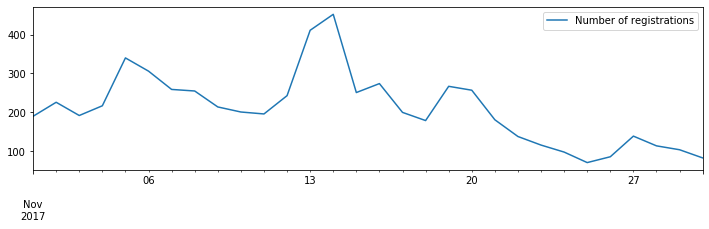

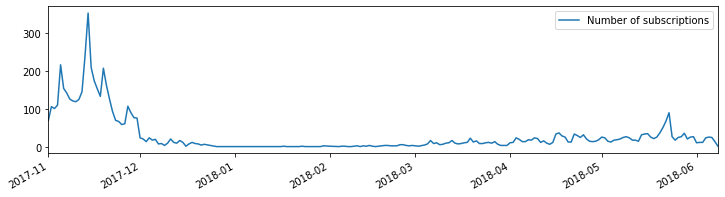

In [9]:
num_reg_df.T.plot(figsize=[12, 3])
plt.show()
print('\n\n')
num_sub_df.T.plot(figsize=[12, 3])
plt.show()

# 3. Probabilidades

Como estamos interessados no dias passados para a compra de um plano premium, começamos vendo a diferença, em dias, entre a data do registro e a data da compra do plano premium. Faremos isso para cada estudante.

In [10]:
diff_df = pd.DataFrame((df['SubscriptionDate'] - df['RegisteredDate']).dt.days, columns=['Days to get premium'])
diff_df.head()

,Days to get premium
StudentId,
98723802,0
86905029,16
40935842,0
83184096,198
12771137,0


Uma primeira abordagem ao problema seria simplesmente contar o número de vezes que ocorreu uma certa diferença e calcular a razão desta com o total. Abaixo nós criamos a lista **probs** que satisfaz a equação abaixo:

$$\textbf{probs}[d] \approx \mathbb{P}(X = d),$$
onde $X$ é o número de dias que um aluno aleatório levou para comprar o plano premium.

In [11]:
max_diff = np.max(diff_df.values)
probs = [100*np.sum(diff_df.values == d)/diff_df.shape[0] for d in range(max_diff)]

Podemos ver no gráfico abaixo que mais ou menos $40 \%$ dos estudantes compra o plano premium nos primeiro dias após ter se registrado. Isso está de acordo com a observação anterior, de que a maior parte compra o plano em novembro, o mesmo mês que fizeram registro na plataforma.  

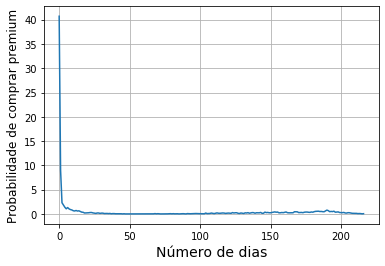

In [14]:
plt.plot(probs)
plt.xlabel('Número de dias', fontsize=14)
plt.ylabel('Probabilidade de comprar premium', fontsize=12)
plt.grid()
plt.show()

Uma limitação desta abordagem é o fato de que há alguns dias específicos com zero ocorrências, mesmo que os dias vizinhos não tenham zero ocorrências. Por exemplo **prob**[85] = 0, mas isto é apenas um fator aleatório, não significa que ninguém nunca irá comprar um plano premium após 85 dias. Com mais dados certamente iríamos observar alguma ocorrência. De todo modo, afim de evitar este tipo de coisa, talvez seja mais interessante fazer um histograma e então obter a curva de densidade da função de probabilidade.

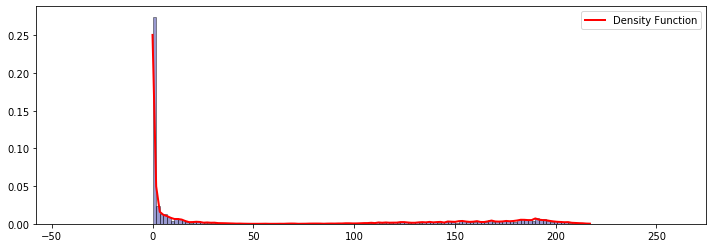

In [13]:
fig, ax = plt.subplots(figsize=[12, 4])
lw = 2
num_bins = 120
hist, bins = np.histogram(diff_df, density=True, bins=num_bins)
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(diff_df)
log_dens = kde.score_samples(bins[:, np.newaxis])

ax.plot(bins[:, np.newaxis], np.exp(log_dens), color='red', lw=lw, linestyle='-', label='Density Function')
ax = sns.distplot(diff_df, hist=True, kde=True, 
             bins=num_bins, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 0})
ax.legend()
plt.show()

Vamos denotar por $f$ a função de densidade de probabilidade e $F$ a função de distribuição acumulada correspondente. Deste modo, a probabilidade de um estudante comprar um plano premium entre $d_1$ e $d_2$ dias é dada por
$$\mathbb{P}(d_1 \leq X \leq d_2) = \int_{d_1}^{d_2} f(x) \ dx = F(d_2) - F(d_1).$$

Usando a densidade obtida pela função *KernelDensity* acima, podemos começar a estimar probabilidades à vontade.

In [14]:
def integrate(delta_x, y):
    """
    Computes the area below curve y, with bins of width delta_x.
    
    Parameters:
    delta_x: positive float
        Bins width
    y: float array
        Image of some function f(x) = y.
        
    Returns:
    area: float
    """
    
    area = delta_x * np.sum(y)
    if area > 1:
        area = 1
    return area

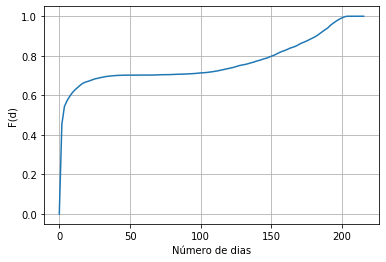

In [15]:
# Criamos a função de de densidade f e a função de distribuição acumulada F.
x = bins[:-1]
f = np.exp(log_dens)
delta_x = abs(x[1] - x[0]) 

F = []
for i in range(num_bins):
    F.append(integrate(delta_x, f[:i]))
    
plt.plot(x, F)
plt.grid()
plt.xlabel('Número de dias')
plt.ylabel('F(d)')
plt.show()

Agora podemos fazer algumas estimativas. Há apenas um detalhe para ser ajeitado. O número de bins usado para fazer o histograma não coincide com o número total de dias. Se quisermos calcular **F**[10], temos que encontrar o índice i tal que **x**[i] é o mais próximo de 10. Daí calculamos **F**[**x**[i]]. A pequena rotina abaixo realiza esta tarefa, e é ela que devemos utilizar para calcular as probabilidades. 

In [16]:
def prob(d1, d2, x, F):
    """
    This function computes the probability that a student will buy the 
    premium plan in d days, where d1 <= d <= d2.
    
    Parameters:
    d1, d2: int
        d1 to d2 is the range of days since the registration
    x: float array
        The bins used to create the histogram and construct F
    F: float array
        Cumulative distribution function
        
    Returns:
    p: float
    """
    
    d1 = (np.abs(x - d1)).argmin()
    d2 = (np.abs(x - d2)).argmin()
    p = F[d2] - F[d1]
    return 100*p

In [17]:
print('De 0 a 3 dias -> {0:.2f} %'.format(prob(0, 3, x, F)))
print('De 4 a 8 dias -> {0:.2f} %'.format(prob(4, 8, x, F)))
print('De 8 a 30 dias -> {0:.2f} %'.format(prob(8, 30, x, F)))
print('De 30 a 200 dias -> {0:.2f} %'.format(prob(30, 200, x, F)))

De 0 a 3 dias -> 54.32 %
De 4 a 8 dias -> 5.00 %
De 8 a 30 dias -> 9.85 %
De 30 a 200 dias -> 30.25 %
